## Importy

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import plotly.graph_objs as go
import wandb
from wandb.keras import WandbMetricsLogger

In [3]:
from utils import *

## Funkcje

In [4]:
dataframes = read_csv("./datasets", 'csv')

In [5]:
res = prepare_dataframes(dataframes)

  0%|          | 0/3 [00:00<?, ?it/s]

out_hum
pressure
out_temp


In [6]:
# res

## Predykcja, kiedyw wystąpiły opady

### Dodawanie informacji o ilości opadów

In [7]:
df = get_labels(res, '2024-02-13')

In [8]:
# df.head(10)
# rain_1h - Rain volume for the last hour, mm
# snow_1h - Snow volume for the last hour, mm (in liquid state)
# https://openweathermap.org/history-bulk

In [9]:
df['rain_1h'] = df['rain_1h'].fillna(0)

In [10]:
df['snow_1h'] = df['snow_1h'].fillna(0)

In [11]:
df['total percipitation'] = df['rain_1h'] + df['snow_1h']

In [12]:
# df[(df['last_changed'] > '2023-12-02 17:00:00+00:00') & (df['last_changed'] < '2023-12-02 22:00:00+00:00')].head(50)

In [13]:
df['last_changed_count'] = df.groupby('last_changed')['last_changed'].transform('count')

In [14]:
df = df.drop_duplicates(subset=['last_changed'])

In [15]:
# df

In [16]:
df = df.loc[:, ['last_changed', 'pressure', 'out_temp', 'out_hum', 'total percipitation']]

In [17]:
df = df.reset_index(drop=True)

### Tabela 1 (time, P, T, H, R)

In [18]:
df

,last_changed,pressure,out_temp,out_hum,total percipitation
0,2023-09-20 00:00:00+00:00,986.000000,15.300000,76.000000,0.00
1,2023-09-20 01:00:00+00:00,985.428571,14.528571,78.900000,0.00
2,2023-09-20 02:00:00+00:00,985.760000,14.212500,79.500000,0.00
3,2023-09-20 03:00:00+00:00,985.280000,14.041667,81.300000,0.00
4,2023-09-20 04:00:00+00:00,985.666667,13.833333,83.333333,0.25
...,...,...,...,...,...
3499,2024-02-12 19:00:00+00:00,974.777778,7.220000,85.166667,0.00
3500,2024-02-12 20:00:00+00:00,975.846154,7.020000,84.933333,0.00
3501,2024-02-12 21:00:00+00:00,976.846154,6.566667,84.033333,0.00
3502,2024-02-12 22:00:00+00:00,976.521739,6.370000,83.873913,0.00


In [19]:
df.value_counts('total percipitation')

total percipitation
0.00     2666
0.25      166
0.51      149
0.38       37
1.02       29
         ... 
1.53        1
1.59        1
1.61        1
1.66        1
30.99       1
Name: count, Length: 119, dtype: int64

### Tabela 2 (time, 0, -1, -2, -3...)

In [20]:
df2 = generate_data(df, 5)
df2

,time,TP t+1,Press t0,Temp t0,Hum t0,TP t0,Press t-1,Temp t-1,Hum t-1,TP t-1,...,Hum t-3,TP t-3,Press t-4,Temp t-4,Hum t-4,TP t-4,Press t-5,Temp t-5,Hum t-5,TP t-5
0,2023-09-20 05:00:00+00:00,0.0,986.217391,13.966667,83.366667,0.0,985.666667,13.833333,83.333333,0.25,...,79.500000,0.00,985.428571,14.528571,78.900000,0.00,986.000000,15.300000,76.000000,0.00
1,2023-09-20 06:00:00+00:00,0.0,986.478261,14.640000,80.100000,0.0,986.217391,13.966667,83.366667,0.00,...,81.300000,0.00,985.760000,14.212500,79.500000,0.00,985.428571,14.528571,78.900000,0.00
2,2023-09-20 07:00:00+00:00,0.0,986.739130,15.480000,75.420000,0.0,986.478261,14.640000,80.100000,0.00,...,83.333333,0.25,985.280000,14.041667,81.300000,0.00,985.760000,14.212500,79.500000,0.00
3,2023-09-20 08:00:00+00:00,0.0,986.090909,17.000000,69.840000,0.0,986.739130,15.480000,75.420000,0.00,...,83.366667,0.00,985.666667,13.833333,83.333333,0.25,985.280000,14.041667,81.300000,0.00
4,2023-09-20 09:00:00+00:00,0.0,986.200000,18.600000,61.920000,0.0,986.090909,17.000000,69.840000,0.00,...,80.100000,0.00,986.217391,13.966667,83.366667,0.00,985.666667,13.833333,83.333333,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3493,2024-02-12 18:00:00+00:00,0.0,974.642857,7.371429,84.830000,0.0,973.500000,7.540000,84.800000,0.00,...,83.640000,0.00,971.652174,7.860000,85.928571,0.00,971.130435,7.955556,86.000000,0.00
3494,2024-02-12 19:00:00+00:00,0.0,974.777778,7.220000,85.166667,0.0,974.642857,7.371429,84.830000,0.00,...,83.020000,0.00,972.384615,7.877778,83.640000,0.00,971.652174,7.860000,85.928571,0.00
3495,2024-02-12 20:00:00+00:00,0.0,975.846154,7.020000,84.933333,0.0,974.777778,7.220000,85.166667,0.00,...,84.800000,0.00,973.222222,7.754545,83.020000,0.00,972.384615,7.877778,83.640000,0.00
3496,2024-02-12 21:00:00+00:00,0.0,976.846154,6.566667,84.033333,0.0,975.846154,7.020000,84.933333,0.00,...,84.830000,0.00,973.500000,7.540000,84.800000,0.00,973.222222,7.754545,83.020000,0.00


## Inny podział danych - testy 21.04.2024

In [21]:
df2 = generate_data(df, 5)

In [22]:
df2

,time,TP t+1,Press t0,Temp t0,Hum t0,TP t0,Press t-1,Temp t-1,Hum t-1,TP t-1,...,Hum t-3,TP t-3,Press t-4,Temp t-4,Hum t-4,TP t-4,Press t-5,Temp t-5,Hum t-5,TP t-5
0,2023-09-20 05:00:00+00:00,0.0,986.217391,13.966667,83.366667,0.0,985.666667,13.833333,83.333333,0.25,...,79.500000,0.00,985.428571,14.528571,78.900000,0.00,986.000000,15.300000,76.000000,0.00
1,2023-09-20 06:00:00+00:00,0.0,986.478261,14.640000,80.100000,0.0,986.217391,13.966667,83.366667,0.00,...,81.300000,0.00,985.760000,14.212500,79.500000,0.00,985.428571,14.528571,78.900000,0.00
2,2023-09-20 07:00:00+00:00,0.0,986.739130,15.480000,75.420000,0.0,986.478261,14.640000,80.100000,0.00,...,83.333333,0.25,985.280000,14.041667,81.300000,0.00,985.760000,14.212500,79.500000,0.00
3,2023-09-20 08:00:00+00:00,0.0,986.090909,17.000000,69.840000,0.0,986.739130,15.480000,75.420000,0.00,...,83.366667,0.00,985.666667,13.833333,83.333333,0.25,985.280000,14.041667,81.300000,0.00
4,2023-09-20 09:00:00+00:00,0.0,986.200000,18.600000,61.920000,0.0,986.090909,17.000000,69.840000,0.00,...,80.100000,0.00,986.217391,13.966667,83.366667,0.00,985.666667,13.833333,83.333333,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3493,2024-02-12 18:00:00+00:00,0.0,974.642857,7.371429,84.830000,0.0,973.500000,7.540000,84.800000,0.00,...,83.640000,0.00,971.652174,7.860000,85.928571,0.00,971.130435,7.955556,86.000000,0.00
3494,2024-02-12 19:00:00+00:00,0.0,974.777778,7.220000,85.166667,0.0,974.642857,7.371429,84.830000,0.00,...,83.020000,0.00,972.384615,7.877778,83.640000,0.00,971.652174,7.860000,85.928571,0.00
3495,2024-02-12 20:00:00+00:00,0.0,975.846154,7.020000,84.933333,0.0,974.777778,7.220000,85.166667,0.00,...,84.800000,0.00,973.222222,7.754545,83.020000,0.00,972.384615,7.877778,83.640000,0.00
3496,2024-02-12 21:00:00+00:00,0.0,976.846154,6.566667,84.033333,0.0,975.846154,7.020000,84.933333,0.00,...,84.830000,0.00,973.500000,7.540000,84.800000,0.00,973.222222,7.754545,83.020000,0.00


In [23]:
training_set = df2[df2['time'] < '2023-12-13 22:00:00+00:00']

In [24]:
validation_set = df2[(df2['time'] < '2024-01-13 22:00:00+00:00') & (df2['time'] >= '2023-12-13 22:00:00+00:00')]
testing_set = df2[(df2['time'] <= '2024-02-13 22:00:00+00:00') & (df2['time'] >= '2024-01-13 22:00:00+00:00')  ]

In [25]:
training_set

,time,TP t+1,Press t0,Temp t0,Hum t0,TP t0,Press t-1,Temp t-1,Hum t-1,TP t-1,...,Hum t-3,TP t-3,Press t-4,Temp t-4,Hum t-4,TP t-4,Press t-5,Temp t-5,Hum t-5,TP t-5
0,2023-09-20 05:00:00+00:00,0.00,986.217391,13.966667,83.366667,0.00,985.666667,13.833333,83.333333,0.25,...,79.500000,0.00,985.428571,14.528571,78.900000,0.00,986.000000,15.300000,76.000000,0.00
1,2023-09-20 06:00:00+00:00,0.00,986.478261,14.640000,80.100000,0.00,986.217391,13.966667,83.366667,0.00,...,81.300000,0.00,985.760000,14.212500,79.500000,0.00,985.428571,14.528571,78.900000,0.00
2,2023-09-20 07:00:00+00:00,0.00,986.739130,15.480000,75.420000,0.00,986.478261,14.640000,80.100000,0.00,...,83.333333,0.25,985.280000,14.041667,81.300000,0.00,985.760000,14.212500,79.500000,0.00
3,2023-09-20 08:00:00+00:00,0.00,986.090909,17.000000,69.840000,0.00,986.739130,15.480000,75.420000,0.00,...,83.366667,0.00,985.666667,13.833333,83.333333,0.25,985.280000,14.041667,81.300000,0.00
4,2023-09-20 09:00:00+00:00,0.00,986.200000,18.600000,61.920000,0.00,986.090909,17.000000,69.840000,0.00,...,80.100000,0.00,986.217391,13.966667,83.366667,0.00,985.666667,13.833333,83.333333,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028,2023-12-13 17:00:00+00:00,0.25,974.354430,3.105556,90.666667,0.00,974.202532,3.410000,89.710000,0.14,...,89.515385,0.00,973.400000,4.169231,90.266667,0.00,973.230769,4.118182,90.750000,0.00
2029,2023-12-13 18:00:00+00:00,0.89,974.506329,3.172222,91.333333,0.25,974.354430,3.105556,90.666667,0.00,...,89.200000,0.00,973.550000,4.038462,89.515385,0.00,973.400000,4.169231,90.266667,0.00
2030,2023-12-13 19:00:00+00:00,0.64,974.658228,3.233333,91.766667,0.89,974.506329,3.172222,91.333333,0.25,...,89.710000,0.14,974.050633,3.745455,89.200000,0.00,973.550000,4.038462,89.515385,0.00
2031,2023-12-13 20:00:00+00:00,0.25,974.810127,3.283333,92.038462,0.64,974.658228,3.233333,91.766667,0.89,...,90.666667,0.00,974.202532,3.410000,89.710000,0.14,974.050633,3.745455,89.200000,0.00


In [26]:
validation_set

,time,TP t+1,Press t0,Temp t0,Hum t0,TP t0,Press t-1,Temp t-1,Hum t-1,TP t-1,...,Hum t-3,TP t-3,Press t-4,Temp t-4,Hum t-4,TP t-4,Press t-5,Temp t-5,Hum t-5,TP t-5
2033,2023-12-13 22:00:00+00:00,0.00,975.277778,3.250000,92.750000,0.00,974.962025,3.272727,92.490909,0.25,...,91.766667,0.89,974.506329,3.172222,91.333333,0.25,974.354430,3.105556,90.666667,0.00
2034,2023-12-13 23:00:00+00:00,0.00,975.944444,3.247826,92.773333,0.00,975.277778,3.250000,92.750000,0.00,...,92.038462,0.64,974.658228,3.233333,91.766667,0.89,974.506329,3.172222,91.333333,0.25
2035,2023-12-14 00:00:00+00:00,0.00,976.363636,3.266667,92.744444,0.00,975.944444,3.247826,92.773333,0.00,...,92.490909,0.25,974.810127,3.283333,92.038462,0.64,974.658228,3.233333,91.766667,0.89
2036,2023-12-14 01:00:00+00:00,0.00,976.727273,3.175000,92.875000,0.00,976.363636,3.266667,92.744444,0.00,...,92.750000,0.00,974.962025,3.272727,92.490909,0.25,974.810127,3.283333,92.038462,0.64
2037,2023-12-14 02:00:00+00:00,0.25,977.117647,3.038462,92.250000,0.00,976.727273,3.175000,92.875000,0.00,...,92.773333,0.00,975.277778,3.250000,92.750000,0.00,974.962025,3.272727,92.490909,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2772,2024-01-13 17:00:00+00:00,4.57,978.882353,-0.066667,89.933333,0.15,980.040000,0.000000,89.286667,0.15,...,87.200000,0.10,982.300000,-0.320000,87.475000,0.00,982.500000,-0.580000,86.350000,0.00
2773,2024-01-13 18:00:00+00:00,0.24,978.176471,-0.233333,92.533333,4.57,978.882353,-0.066667,89.933333,0.15,...,88.550000,0.10,981.090909,-0.042857,87.200000,0.10,982.300000,-0.320000,87.475000,0.00
2774,2024-01-13 19:00:00+00:00,0.37,977.000000,-0.333333,92.785714,0.24,978.176471,-0.233333,92.533333,4.57,...,89.286667,0.15,980.520000,-0.050000,88.550000,0.10,981.090909,-0.042857,87.200000,0.10
2775,2024-01-13 20:00:00+00:00,0.37,976.600000,-0.477778,93.187500,0.37,977.000000,-0.333333,92.785714,0.24,...,89.933333,0.15,980.040000,0.000000,89.286667,0.15,980.520000,-0.050000,88.550000,0.10


In [27]:
testing_set

,time,TP t+1,Press t0,Temp t0,Hum t0,TP t0,Press t-1,Temp t-1,Hum t-1,TP t-1,...,Hum t-3,TP t-3,Press t-4,Temp t-4,Hum t-4,TP t-4,Press t-5,Temp t-5,Hum t-5,TP t-5
2777,2024-01-13 22:00:00+00:00,0.35,975.800000,-0.408333,93.675000,0.47,975.750000,-0.412500,93.450000,0.37,...,92.785714,0.24,978.176471,-0.233333,92.533333,4.57,978.882353,-0.066667,89.933333,0.15
2778,2024-01-13 23:00:00+00:00,0.51,974.800000,-0.280000,93.970588,0.35,975.800000,-0.408333,93.675000,0.47,...,93.187500,0.37,977.000000,-0.333333,92.785714,0.24,978.176471,-0.233333,92.533333,4.57
2779,2024-01-14 00:00:00+00:00,0.25,973.166667,-0.128571,94.800000,0.51,974.800000,-0.280000,93.970588,0.35,...,93.450000,0.37,976.600000,-0.477778,93.187500,0.37,977.000000,-0.333333,92.785714,0.24
2780,2024-01-14 01:00:00+00:00,0.21,972.700000,-0.021429,94.880000,0.25,973.166667,-0.128571,94.800000,0.51,...,93.675000,0.47,975.750000,-0.412500,93.450000,0.37,976.600000,-0.477778,93.187500,0.37
2781,2024-01-14 02:00:00+00:00,0.21,971.785714,0.175000,94.033333,0.21,972.700000,-0.021429,94.880000,0.25,...,93.970588,0.35,975.800000,-0.408333,93.675000,0.47,975.750000,-0.412500,93.450000,0.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3493,2024-02-12 18:00:00+00:00,0.00,974.642857,7.371429,84.830000,0.00,973.500000,7.540000,84.800000,0.00,...,83.640000,0.00,971.652174,7.860000,85.928571,0.00,971.130435,7.955556,86.000000,0.00
3494,2024-02-12 19:00:00+00:00,0.00,974.777778,7.220000,85.166667,0.00,974.642857,7.371429,84.830000,0.00,...,83.020000,0.00,972.384615,7.877778,83.640000,0.00,971.652174,7.860000,85.928571,0.00
3495,2024-02-12 20:00:00+00:00,0.00,975.846154,7.020000,84.933333,0.00,974.777778,7.220000,85.166667,0.00,...,84.800000,0.00,973.222222,7.754545,83.020000,0.00,972.384615,7.877778,83.640000,0.00
3496,2024-02-12 21:00:00+00:00,0.00,976.846154,6.566667,84.033333,0.00,975.846154,7.020000,84.933333,0.00,...,84.830000,0.00,973.500000,7.540000,84.800000,0.00,973.222222,7.754545,83.020000,0.00


In [28]:
X_train = training_set.iloc[:,2:]
y_train = training_set.iloc[:,1:2]

X_val = validation_set.iloc[:,2:]
y_val = validation_set.iloc[:,1:2]

X_test = testing_set.iloc[:,2:]
y_test = testing_set.iloc[:,1:2]

In [29]:
len(X_train.index), len(X_val.index), len(X_test.index)

(2033, 744, 721)

In [30]:
len(y_train.index), len(y_val.index), len(y_test.index)

(2033, 744, 721)

In [31]:
X_test

,Press t0,Temp t0,Hum t0,TP t0,Press t-1,Temp t-1,Hum t-1,TP t-1,Press t-2,Temp t-2,...,Hum t-3,TP t-3,Press t-4,Temp t-4,Hum t-4,TP t-4,Press t-5,Temp t-5,Hum t-5,TP t-5
2777,975.800000,-0.408333,93.675000,0.47,975.750000,-0.412500,93.450000,0.37,976.600000,-0.477778,...,92.785714,0.24,978.176471,-0.233333,92.533333,4.57,978.882353,-0.066667,89.933333,0.15
2778,974.800000,-0.280000,93.970588,0.35,975.800000,-0.408333,93.675000,0.47,975.750000,-0.412500,...,93.187500,0.37,977.000000,-0.333333,92.785714,0.24,978.176471,-0.233333,92.533333,4.57
2779,973.166667,-0.128571,94.800000,0.51,974.800000,-0.280000,93.970588,0.35,975.800000,-0.408333,...,93.450000,0.37,976.600000,-0.477778,93.187500,0.37,977.000000,-0.333333,92.785714,0.24
2780,972.700000,-0.021429,94.880000,0.25,973.166667,-0.128571,94.800000,0.51,974.800000,-0.280000,...,93.675000,0.47,975.750000,-0.412500,93.450000,0.37,976.600000,-0.477778,93.187500,0.37
2781,971.785714,0.175000,94.033333,0.21,972.700000,-0.021429,94.880000,0.25,973.166667,-0.128571,...,93.970588,0.35,975.800000,-0.408333,93.675000,0.47,975.750000,-0.412500,93.450000,0.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3493,974.642857,7.371429,84.830000,0.00,973.500000,7.540000,84.800000,0.00,973.222222,7.754545,...,83.640000,0.00,971.652174,7.860000,85.928571,0.00,971.130435,7.955556,86.000000,0.00
3494,974.777778,7.220000,85.166667,0.00,974.642857,7.371429,84.830000,0.00,973.500000,7.540000,...,83.020000,0.00,972.384615,7.877778,83.640000,0.00,971.652174,7.860000,85.928571,0.00
3495,975.846154,7.020000,84.933333,0.00,974.777778,7.220000,85.166667,0.00,974.642857,7.371429,...,84.800000,0.00,973.222222,7.754545,83.020000,0.00,972.384615,7.877778,83.640000,0.00
3496,976.846154,6.566667,84.033333,0.00,975.846154,7.020000,84.933333,0.00,974.777778,7.220000,...,84.830000,0.00,973.500000,7.540000,84.800000,0.00,973.222222,7.754545,83.020000,0.00


In [32]:
y_test

,TP t+1
2777,0.35
2778,0.51
2779,0.25
2780,0.21
2781,0.21
...,...
3493,0.00
3494,0.00
3495,0.00
3496,0.00


## LSTM testing - inny podział danych

In [53]:
wandb.init(project='LSTM rainfall prediction', name = 'Oskar Test')
#inny podział danych IPD

In [54]:
config = wandb.config

config["step"] = 5
config["epsilon"] = 'None' #1e-3 jakieś najlepsze... -> 1e-5 gorsze wyniki

config["units 1st layer"] = 50
config["dropout 1st layer"] = 0.2
config["units 2nd layer"] = 50
#config["dropout 2nd layer"] = 0.2
config["units 3rd layer"] = 50
#config["dropout 3rd layer"] = 0.2
config["units 4th layer"] = 50
config["dropout 4th layer"] = 'None'
config["learning rate"] = 1e-5
config["optimizer"] = 'adam'
config["loss"] = 'mean_squared_error'

config["epochs"] = 10
config["batch size"] = 32

config['MSE'] = 0
config['R2'] = 0

In [55]:
df2 = generate_data(df, 5)
training_set = df2[df2['time'] < '2023-12-13 22:00:00+00:00']
validation_set = df2[(df2['time'] < '2024-01-13 22:00:00+00:00') & (df2['time'] >= '2023-12-13 22:00:00+00:00')]
testing_set = df2[(df2['time'] <= '2024-02-13 22:00:00+00:00') & (df2['time'] >= '2024-01-13 22:00:00+00:00') ]

X_train = training_set.iloc[:,2:]
y_train = training_set.iloc[:,1:2]

X_val = validation_set.iloc[:,2:]
y_val = validation_set.iloc[:,1:2]

X_test = testing_set.iloc[:,2:]
y_test = testing_set.iloc[:,1:2]

len(X_train.index), len(X_val.index), len(X_test.index)

(2033, 744, 721)

In [56]:
#Reshaping, dodanie wymiarów
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(observation, timesteps, predictors)

In [57]:
#Initializing RNN

regressor = Sequential()

#Adding first layer of LTSM and Dropout regularization
regressor.add(
    LSTM(
        units=config["units 1st layer"],
        return_sequences=True,
        input_shape=(X_train.shape[1], 1),
    )
)
regressor.add(Dropout(config["dropout 1st layer"]))

#Adding second layer of LTSM and Dropout regularization
regressor.add(LSTM(units=config["units 2nd layer"], return_sequences=True))
#regressor.add(Dropout(config["dropout 2nd layer"] ))

#Adding third layer of LTSM and Dropout regularization
regressor.add(LSTM(units=config["units 3rd layer"]))
#regressor.add(Dropout(config["dropout 3rd layer"] ))

#Adding output layer
regressor.add(Dense(units=1)) # , activation='relu'

#Learning rate
optimizer = Adam(learning_rate=config["learning rate"]) 

#Compiling
regressor.compile(optimizer=optimizer, loss=config["loss"])

C:\Users\Wiki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [58]:
regressor.fit(
    X_train, 
    y_train, 
    epochs=config["epochs"], 
    batch_size=config["batch size"], 
    callbacks=[WandbMetricsLogger()]
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.5577
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.6034
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.6416
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.7422
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.0069
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.7895
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.9185
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.4639
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.6803
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.6724


In [59]:
y_pred = regressor.predict(X_val)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


In [60]:
y_pred = pd.DataFrame(y_pred, columns =['TP t+1'])

In [61]:
y_val = y_val.reset_index(drop=True)

In [62]:
y_val.compare(y_pred)

TP t+1          
      self     other
0     0.00  0.181381
1     0.00  0.179164
2     0.00  0.175893
3     0.00  0.173576
4     0.25  0.172297
..     ...       ...
739   4.57  0.109963
740   0.24  0.124135
741   0.37  0.126560
742   0.37  0.127086
743   0.47  0.124780

[744 rows x 2 columns]

In [63]:
y_pred = y_pred.rename(columns={'TP t+1':'Predicted TP'})

In [64]:
res = pd.concat([y_pred, y_val], axis=1)

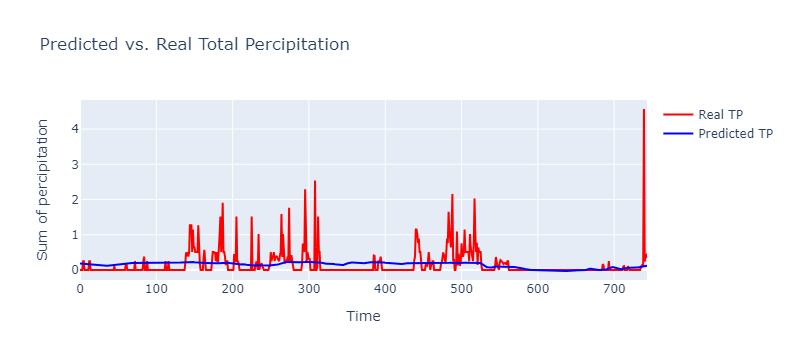

In [65]:
trace1 = go.Scatter(
    x=res.index, y=res['TP t+1'], mode='lines', name='Real TP', line=dict(color='red')
)
trace2 = go.Scatter(
    x=res.index, y=res['Predicted TP'], mode='lines', name='Predicted TP', line=dict(color='blue')
)

fig = go.Figure()

fig.add_trace(trace1)
fig.add_trace(trace2)

fig.update_layout(
    title='Predicted vs. Real Total Percipitation',
    xaxis_title='Time',
    yaxis_title='Sum of percipitation')

fig.show()

In [66]:
MSE = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
 
print(
    f'Mean Squared Error: {MSE}\n',
    f'R2 coefficient: {r2}',
 )

Mean Squared Error: 0.12267429194112778
 R2 coefficient: 0.0660920685879447


In [67]:
# regressor.get_config()

In [68]:
regressor.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 24, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 24, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 152,555 (595.92 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 101,704 (397.29 KB)

In [69]:
regressor.loss

'mean_squared_error'

In [70]:
regressor.optimizer

In [72]:
wandb.config.update({"MSE": MSE, "R2": r2})
wandb.finish()

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,▃▅▂▂▁▁▃█▂▂
epoch/epoch,9
epoch/loss,0.65899
